In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.1889, 0.0101, 0.2874, 0.1179, 0.3415, 0.0542],
        [0.0854, 0.2359, 0.2526, 0.1862, 0.1548, 0.0851],
        [0.2288, 0.2817, 0.1884, 0.1595, 0.1379, 0.0036],
        [0.1950, 0.2042, 0.2724, 0.1469, 0.1610, 0.0205],
        [0.0550, 0.2823, 0.3104, 0.0526, 0.2871, 0.0127]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [50]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        self.topk_num = 1
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Establish normalized subgroups
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-2), previous_transition_tensor), dim=1)
        batch_size, num_groups, n_features = norm_subgroups.shape
        
        # Compute scores for each normalized subgroup
        scores = self.attention_weights(norm_subgroups).sum(-1) # [batch_size, num_groups]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, num_groups]
        
        top_selections = torch.topk(weights, self.topk_num)
        top_selections_indices = top_selections.indices
        
        selected_interaction_tensors = torch.empty(batch_size, n_features, n_features, n_features, self.topk_num)
        selected_norm_subgroups = torch.empty(batch_size, self.topk_num, n_features)
        
        for batch in range(batch_size):
            selected_interaction_tensors[batch] = self.interaction_tensors[:, :, :, top_selections_indices[batch]]
            selected_norm_subgroups[batch] = norm_subgroups[batch, top_selections_indices[batch], :]
        
        selected_transition_tensors = torch.einsum('bijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
        
        # Generate state tensors from the interaction tensor
        
        new_state_tensors = torch.einsum('bjks,bj->bks',selected_transition_tensors, state_tensor)
        
        # Sum into a new state tensor
        new_state_tensor = torch.mean(new_state_tensors, dim = -1)
        
        softmax_tensor = torch.softmax(new_state_tensor, dim = 1)
        
        # We need a single transition tensor so we will average this as well
        selected_transition_tensor = torch.mean(selected_transition_tensors, dim = -1)
        
        return softmax_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


In [51]:
import torch

# Assuming dimensions for demonstration
batch = 2
n_features = 3
slices = 4

# Simulating the tensors
tensor1 = torch.randn(batch, n_features, n_features, n_features, slices)
tensor2 = torch.randn(batch, slices, n_features)

result = torch.einsum('bijks,bsi->bjks', tensor1, tensor2)

# Since the multiplication should retain the original shape of tensor1 but without one of the n_features dimensions,
# we might not need to sum across dimensions as previously stated, if the multiplication is element-wise per slice.
# However, the result's shape should now be checked to ensure it aligns with expectations.
print("Result shape:", result.shape)


Result shape: torch.Size([2, 3, 3, 4])


# Sequence-to-Sequence Check

In [52]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)

print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


## Consistency Check

In [53]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([-1.3881,  0.1813,  1.7927,  0.2517])
tensor([0.4253, 0.0022, 0.5428, 0.0297], grad_fn=<SliceBackward0>)
tensor([0.4253, 0.0022, 0.5428, 0.0297], grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [54]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([0.4253, 0.0022, 0.5428, 0.0297], grad_fn=<SliceBackward0>)

In [55]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

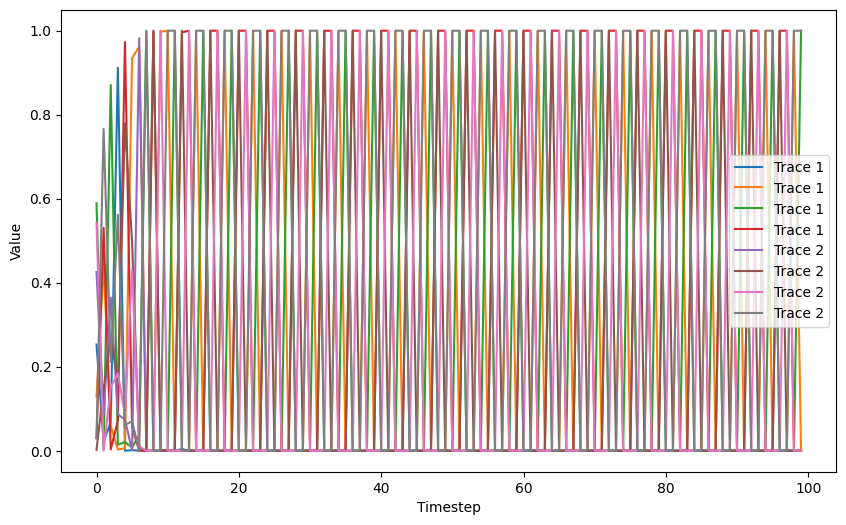

In [56]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

# Example Training

## Simple Data Generation

In [57]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)


In [58]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y


In [59]:
from torch import nn, optim

# Model
model = NeuralCoilLayer(
    n_features = n_features
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/100], Loss: 0.0007083583623170853
Epoch [20/100], Loss: 0.16768772900104523
Epoch [30/100], Loss: 0.1717887669801712
Epoch [40/100], Loss: 0.16835004091262817


KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs, Y, batch_index=1, feature_index=3)


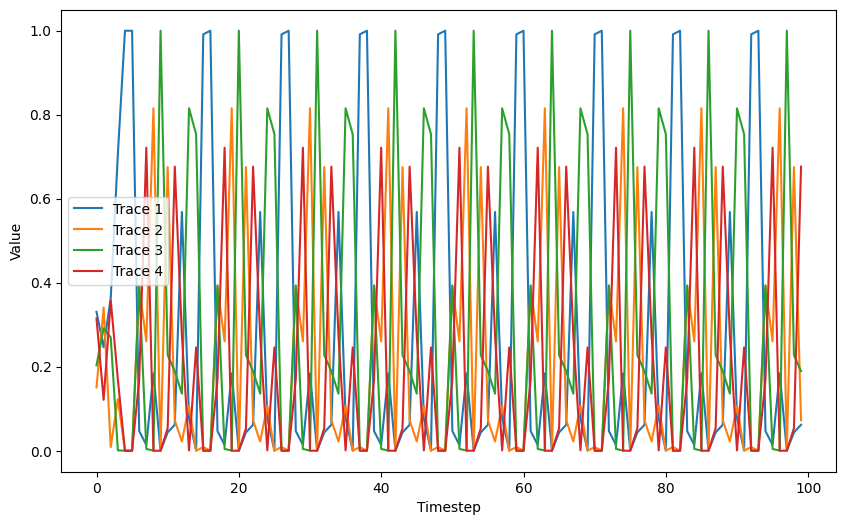

In [ ]:
states = []
batch = 5
state_tensor = outputs[:,length-1,:]
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()